Blake Buckner - December 7th 2024

This is my MS 38 Final Project. This is a program designed to mix computer vision and image generation to make AI automatically play the game telephone with itself. 

This uses the OpenAI Models gpt4o-mini and dall-e, which means to use it you must have an OpenAI api key and some token credits for its use. This means it is not quite free to actually use but the costs are still very minimal. If desired this code could be expanded to use other fully free models but I do not have a direct way to integrate them and they are would likely be worse quality.

First we have to import all of the required libraries for the program

In [1]:
from openai import OpenAI
import matplotlib.pyplot as plt
import requests
from PIL import Image as PILImage
from io import BytesIO
import math
import imageio
from IPython.display import display, Image, clear_output
import time
import os


Innitialize some basic variable settings to be used.

name: The base name of the image and files

detail: How detailed the image will be described

steps: How many rounds will the telephone game run for

dalle_version: Which version of dalle will be used, only integers 2 or 3

prompt: What prompt is being fed to the image description ai for what it is instructed to write when describing the image

start_url: The url for an image that will be used as the initial point to be described


In [2]:
name = "wade"
detail = 200 # roughly 3 characters per
steps = 4 # Adds roughly 10-20 seconds per step
dalle_version = 2
start_url = "https://media-cldnry.s-nbcnews.com/image/upload/t_fit-760w,f_auto,q_auto:best/rockcms/2024-10/dwyane-wade-statue-zz-241028-24b291.jpg"

prompt = f"""   You must use a max of {detail * 3} characters. 
                You are an AI that describes images in great detail. 
                Your task is to look at the input image and provide a comprehensive description.

"""

I have to use the OpenAI api to use their service. Here I import my api key from a seprate file. If using your own you can place the api key in a txt file titled 'api-keys.txt'. or replace api_key within the client variable

In [3]:
with open('api-keys.txt', 'r') as f:
    api_keys = f.read().strip()
api_key_list = api_keys.split(',')

client = OpenAI(api_key=api_key_list[0])

Here we describe how much detail will be in our description of the image. It uses OpenAI gpt4o mini. This will be the description directly fed to the Dall-e image generation model.

In [4]:
def describe_image(prompt,url,detail=100):
  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": prompt},
          {
            "type": "image_url",
            "image_url": {
              "url": url,
            },
          },
        ],
      }
    ],
    max_tokens=detail,
  )
  my_response = response.choices[0].message.content
  return my_response

Next we define the function to generate the image. This takes an input of the image description and generates and image in default 512x512 resolution, and returns the image url.

In [5]:
def generate_image(image_prompt,dalle=2):
  new_img = client.images.generate(
    model=f"dall-e-{dalle}", 
    prompt=image_prompt,
    n=1,
    size="512x512" if dalle == 2 else "1024x1024"
  )
  new_img_url = new_img.data[0].url
  return new_img_url


Here we begin with the actual generation. First we need the base case model instantiation so we describe and generate the first image. This essentially is just the default round one.

In [6]:
# Innitialize generation variables
all_urls = [start_url]
img_description = describe_image(prompt,start_url,detail)
all_descriptions = [img_description]
new_img_url = generate_image(img_description,dalle_version)

Now we need to just loop through for each round of telephone.
It will take a url associated with the image and describes it, then generates again.

In [7]:
# Simulate main rounds 
for i in range(steps-1):
    all_urls.append(new_img_url)
    img_description = describe_image(prompt,new_img_url,detail)
    all_descriptions.append(img_description)
    new_img_url = generate_image(img_description, dalle_version)

We want to add an outputs folder or create one if it doesnt already exist

In [8]:
folder_path = os.path.join('outputs', name)
os.makedirs(folder_path, exist_ok=True)

Each image is saved to the desired folder in outputs

In [9]:
desired_size = (512, 512) # Width, Height 
speed = 2 # How many seconds each frame appears

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
for i, url in enumerate(all_urls):
    response = requests.get(url, headers=headers)
    img = PILImage.open(BytesIO(response.content))
    img = img.resize(desired_size, PILImage.LANCZOS)
    img_path = os.path.join(folder_path, f'{name}_img_{i}.jpg')
    img.save(img_path)


We take the generated descriptions from each round both save to a txt file in the descriptions folder and print them on a new line 

To show all the images together we plot a grid of each image in left to right top to bottom order for when they were generated.

Using each image a gif is created. This is set to a default 512x512 size. 

In [10]:
# Open and write descriptions to a text file inside the new folder
with open(os.path.join(folder_path, f'{name}_descriptions.txt'), 'a') as file:
    for description in all_descriptions:
        file.write(description + '\n\n')

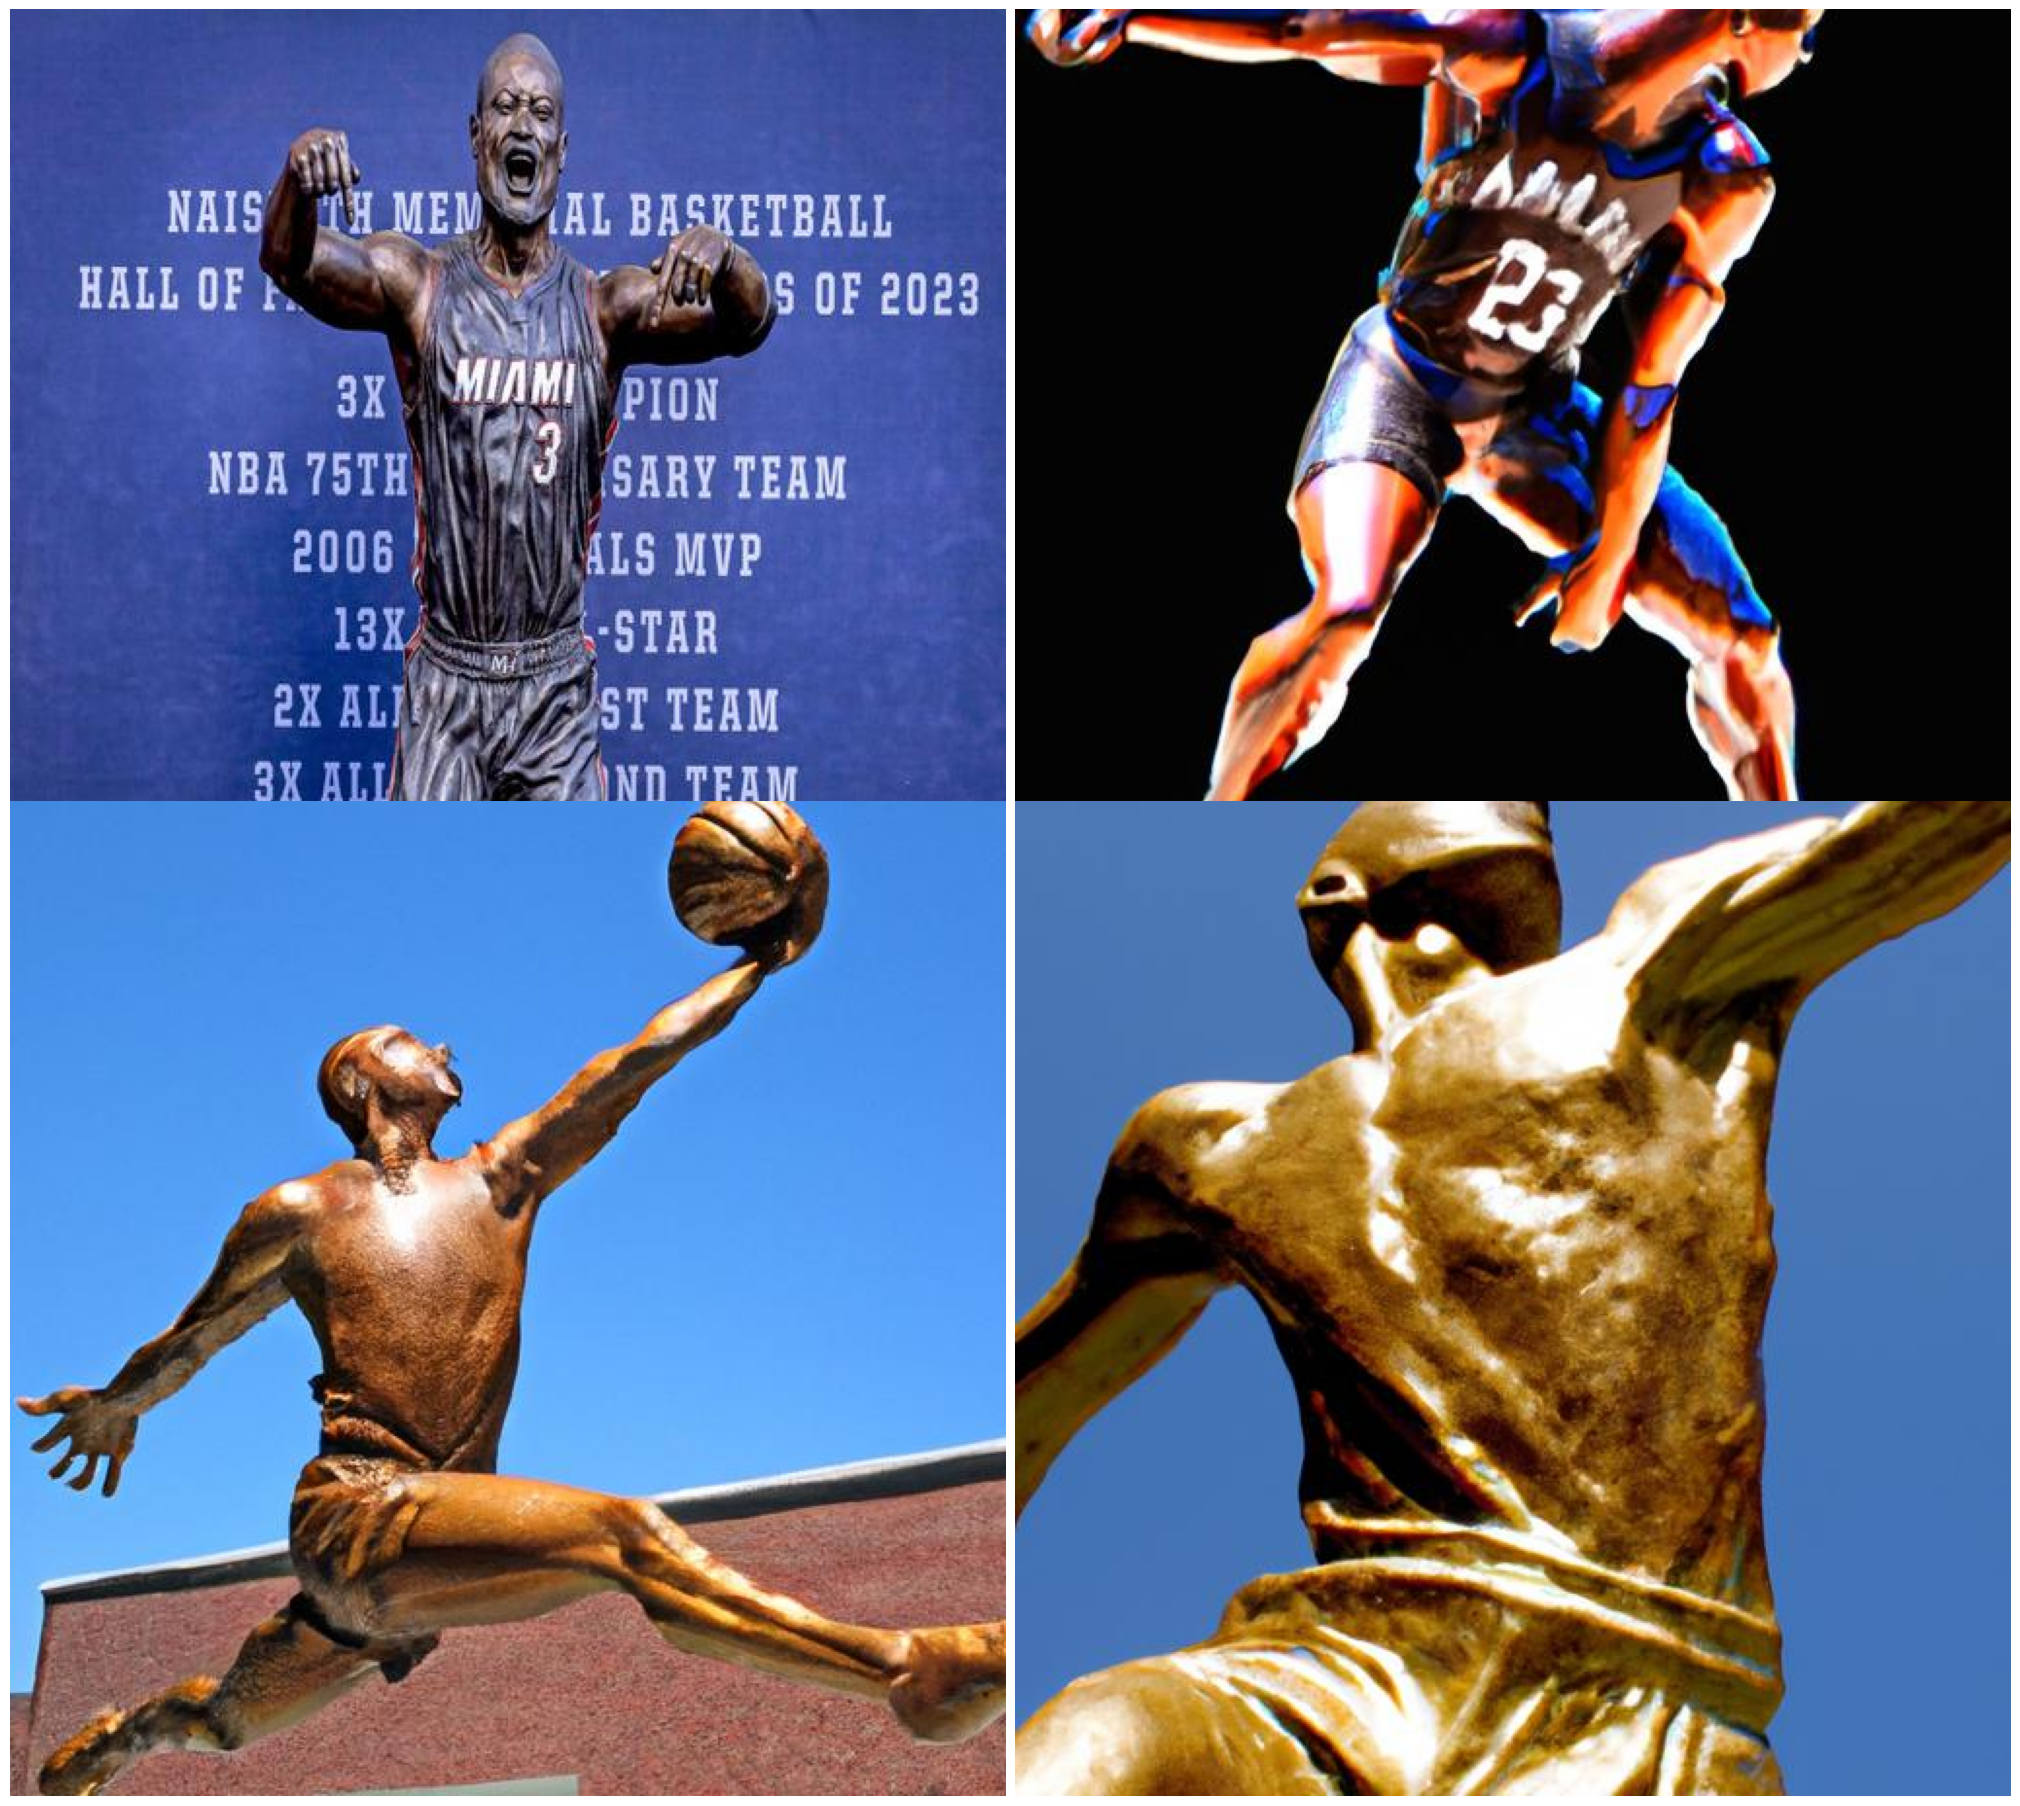

In [11]:
num_images = len(all_urls)
# Calculate number of rows and columns for the grid
cols = math.ceil(math.sqrt(num_images))
rows = math.ceil(num_images / cols)

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

# Loop through the saved images and display each image
for i, ax in enumerate(axes[:num_images]):
    img_path = os.path.join(folder_path, f'{name}_img_{i}.jpg')
    img = PILImage.open(img_path)
    ax.imshow(img)
    ax.axis('off')

# Hide any unused subplots
for ax in axes[num_images:]:
    ax.axis('off')

plt.tight_layout(pad=0, h_pad=-30, w_pad=1, rect=None)

# Save the grid image to the new folder
grid_path = os.path.join(folder_path, f'{name}_grid.png')
plt.savefig(grid_path, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [12]:

# Load the saved images and create a GIF
images = []
for i in range(len(all_urls)):
    img_path = os.path.join(folder_path, f'{name}_img_{i}.jpg')
    img = PILImage.open(img_path)
    img = img.resize(desired_size, PILImage.LANCZOS)  # Ensure all images have the same size
    images.append(img)

# Convert images to a GIF and save it in the new folder
gif_path = os.path.join(folder_path, f'final_{name}.gif')
imageio.mimsave(gif_path, images, format='GIF', loop=0, fps=1/speed)

print(f"GIF saved at {gif_path}")


GIF saved at outputs/wade/final_wade.gif


Now we should have the final product of a gif showing each round.

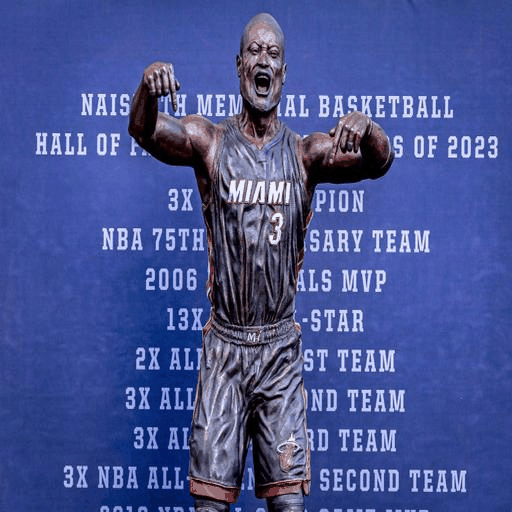

'The image features a bronze statue of a basketball player, who is depicted in an athletic pose, showcasing strength and confidence. The figure is dressed in a black Miami Heat jersey, prominently displaying the word "MIAMI" across the chest and accompanied by the player\'s number on the shorts. The statue stands on a pedestal against a blue backdrop that highlights the "Naismith Memorial Basketball Hall of Fame" and features text detailing the player\'s achievements, including multiple All-Star selections and MVP accolades. The sculpture captures the essence of the athlete\'s legacy in basketball.'

'The image showcases a dynamic sculpture of a basketball player in motion, emanating a sense of energy and athleticism. The figure is depicted in a mid-action pose, wearing a jersey that highlights the number "23." The jersey is adorned with bold lettering, contributing to the figure\'s competitive spirit. The player\'s muscular physique is accentuated, showing defined arms and legs, emphasizing strength and agility. The base of the sculpture is simple, focusing the viewer\'s attention on the player. The contrasting light and shadow create depth, enhancing the three-dimensionality, while the rich colors add vibrancy to the artwork.'

"The image depicts a bronze sculpture of a basketball player in mid-air, performing a dynamic jump. The athlete is captured with an outstretched arm, holding a basketball above his head, suggesting a powerful dunk. His muscular physique is highlighted by the gleaming surface of the bronze, which reflects sunlight, enhancing the sculpture's vibrant details. The figure is dressed in a sleeveless jersey and shorts, and his expression conveys focused determination. The sky above is clear blue, providing a stark contrast to the bronze tones, while a simple building structure appears in the background, emphasizing the statue's prominence."

'The image features a striking sculpture of a male figure in motion, seemingly captured in mid-leap. The statue is rendered in a shiny, gold-toned material, reflecting light beautifully against a clear blue sky. The muscular structure of the figure is well-defined, showcasing athleticism and strength. The arms are outstretched, conveying a sense of dynamism and freedom, while the facial details are minimalistic, focusing more on the overall form. The attire appears to be a simple, form-fitting outfit, highlighting the figure’s physique and adding to the sense of movement and energy in the piece.'

In [13]:
clear_output(wait=True)
display(Image(filename=gif_path))

for description in all_descriptions:
    display(description)
    time.sleep(speed)  # Delay in seconds

